In [ ]:
%matplotlib inline
from pathlib import Path
from time import monotonic, sleep

import numpy as np
import matplotlib.pyplot as plt
import math

import qcodes as qc
from qcodes.dataset import (
    Measurement,
    initialise_or_create_database_at,
    load_by_guid,
    load_by_run_spec,
    load_or_create_experiment,
    plot_dataset,
)
from qcodes.dataset.descriptions.detect_shapes import detect_shape_of_measurement
from qcodes.logger import start_all_logging
start_all_logging()

from scipy.optimize import curve_fit
import numpy as np

from ultolib import (anritsu, korad, spincore)
from ultolib.spincore import pulse
import qcodes.instrument_drivers.stanford_research as stanford_research

In [ ]:
# Note : this will generate two deprecation warnings when creating the pulse_blaster
pulse_blaster = spincore.PulseBlasterESRPRO(name='pulse_blaster', board_number=0)
pulse_blaster.core_clock(500)                     #Sets the clock speed, 
                                                  #must be called immediately after connecting to the PulseBlaster

lock_in_amp = stanford_research.SR830(name='lock_in_amp', address='ASRL5::INSTR', terminator='\r')

microwave_src=anritsu.MG3681A(name='microwave_src', address='ASRL4::INSTR', terminator='\r\n')
microwave_src.output('OFF')
microwave_src.IQ_modulation('EXT')
microwave_src.output_level_unit('dBm')

dc_supply = korad.KD3305P('dc_supply', 'ASRL6::INSTR')
dc_supply.ch1.voltage_setpoint(0)
dc_supply.ch1.current_setpoint(0)

pulse_blaster.stop()

## Preparation
Input the parameters you determined in the ramsey Finges template below before continuing to the Hahn echo experiment.

In [ ]:
dc_supply.ch1.voltage_setpoint(12)
dc_supply.ch1.current_setpoint(#Your Current Setpoint Here)

microwave_src.frequency(#Determined Resonance Frequency Here)
microwave_src.power(#Your Microwave Power Here)

T_X_pi = #Enter the pi rotation pulselength for the I-channel here.
T_Y_pi = #Enter the pi rotation pulselength for the Q-channel here.
T_X_pi_2 = T_X_pi / 2
T_Y_pi_2 = T_Y_pi / 2

## The Hahn Echo

Ia a Hahn echo pulse sequence, we introduce an additional pulse. The sequence looks as follows:

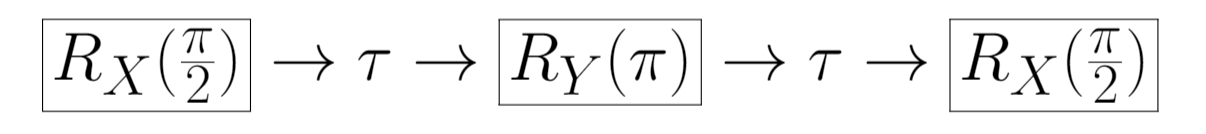

Construct the pulse sequence below using the pre-define timing parameters. The pulse sequence should look similar to:

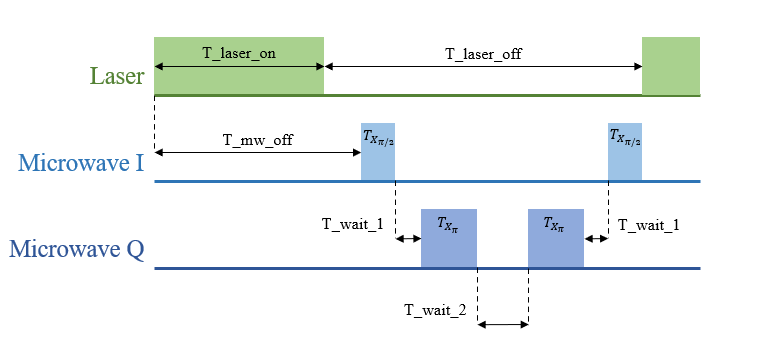

where T_free_prec is 3 $\times$ T_wait.

In [ ]:
#Use this to make a parameter out of anything!
FPT = qc.Parameter("Precession", unit = 's')
LI_R = qc.ManualParameter('Signal', unit='V')

#We start by stopping the laser pulsing. This way we can properly initialize.
initialise_or_create_database_at(Path.cwd() / "Hahn Echo.db")
experiment = load_or_create_experiment(
    experiment_name='Hahn Echo',
    sample_name=""
)

meas = Measurement(exp=experiment, name='Hahn Echo')
meas.register_parameter(FPT)  # register the first independent parameter
meas.register_parameter(LI_R) # now register the dependent oone

In [ ]:
ref_f = 200
ref_D = 0.5
T_ref_on = ref_D/ref_f
T_ref_off = (1 - ref_D)/ref_f

laser_f = 100e3                                 #Laser modulation frequency.
laser_D = 0.3                                   #Laser modulation duty cycle.
T_laser_on = laser_D/laser_f                    #Laser on time. 
T_laser_off = (1 - laser_D)/laser_f             #Laser off time.
N_laser_pulses = round(laser_f/ref_f)           #Number of laser pulses that can fit in the reference period.

T_mw_off =  laser_D/laser_f
N_mw_pulses = round(laser_f/(ref_f*2))          #Number of microwave pulses that can fit in the reference period.
T_mw_on = (1 - laser_D)/laser_f                 #Microwave time on.


lock_in_amp.time_constant(3)#Your time constant here)
lock_in_amp.sensitivity(100e-12)#Your sensitivity here)
microwave_src.power(-10)#Your power here) #<= 15
microwave_src.frequency(2711557788.94472)#Chosen frequency here)

ratio = 5
tau_padding_right = 10e-9
N_mw_pulses = 100
T_pi_on_2 = 72e-6
tau_padding_left = 1e-6

def Hahn_Echo_PP(tau_delay):
    
    N_laser_pulses = 2*N_mw_pulses
    delta_tau_ref = T_ref_on/N_mw_pulses
    tau_padding_right = delta_tau_ref - 2*tau_delay - tau_padding_left - T_laser_on - 4*T_pi_on_2
    
    print(tau_padding_left, tau_padding_right, tau_delay, T_laser_on)
    assert(tau_padding_right >= 0)
    
    pulse_blaster.reset_channel_buffer()  #Clear the previous pulse sequence.
    pulse_blaster.ch0.pulse_sequence_buffer.set(
        [pulse(level=1, duration=T_ref_on), pulse(level=0, duration=T_ref_off)]
    )
    
    pulse_blaster.ch1.pulse_sequence_buffer.set(
        [[pulse(level=1, duration=T_laser_on), pulse(level=0, duration=T_laser_off)] for i in range(0, N_laser_pulses)] 
    )                                     #Define the new pulse sequence for channel 1.

    pulse_blaster.ch2.pulse_sequence_buffer.set(
        [[pulse(level=0, duration=T_laser_on+tau_padding_left), 
          pulse(level=1, duration= T_pi_on_2),  
          pulse(level=0, duration=tau_delay), 
          pulse(level=1, duration=2*T_pi_on_2), 
          pulse(level=0, duration= tau_delay), 
          pulse(level=1, duration = T_pi_on_2),
          pulse(level=0, duration = tau_padding_right)] for i in range(0, N_mw_pulses)] +
        [pulse(level=0, duration=float(T_ref_off))]
    ) 

T_mw_on_examp = 1e-6
Rabi_Osc_PP(T_mw_on_examp)
pulse_blaster.plot_channel_buffer()   #This function plots the newly defined pulse sequence.

In [ ]:
ref_f =                                      #Reference frequency.
ref_D =                                      #Reference duty cycle.
T_ref_on = ref_D/ref_f                       #Reference time on.
T_ref_off = (1 - ref_D)/ref_f                #Reference time off.

laser_f =                                    #Laser modulation frequency.
laser_D =                                    #Laser modulation duty cycle.
T_laser_on =                                 #Laser time on. 
T_laser_off =                                #Laser time off.
N_laser_pulses =                             #Number of laser pulses that can fit in the reference period.

ramsey_f =                                   #Hahn echo repitition rate.
N_hahn =                                     #Number of Hahn echo repitions per reference freuquency period.
def Hahn_T_mw_off(t_free_prec):
    return #Your MW off time here

def Hahn_T_wait(t_free_prec):
    return #Your wait time here

T_free_prec_0 = 200e-9
T_mw_off = Hahn_T_mw_off(T_free_prec_0)
T_wait = Hahn_T_wait(T_free_prec_0)

def Hahn_Echo_X_PP(t_free_prec):
    #TODO: Fill out the pulse sequences below.
    pulse_blaster.reset_channel_buffer()         #Clear the previous pulse sequence.
    pulse_blaster.ch0.pulse_sequence_buffer.set(
        #TODO: Enter the lock-in reference pulse sequence.
    )                                            
    pulse_blaster.ch1.pulse_sequence_buffer.set(
        #TODO: Enter the laser pulse sequence.
    )                                           
    pulse_blaster.ch2.pulse_sequence_buffer.set(
        #TODO: Enter the 'I' microwave modulation pulse sequence.
    )
Hahn_Echo_X_PP(T_free_prec_0)
pulse_blaster.plot_channel_buffer()          #This function plots the newly defined pulse sequence.

In [ ]:
lock_in_amp.time_constant(#Your time constant)
lock_in_amp.sensitivity(#Your sensitivity)

#Set your start/finish times and the step size.
fpt_s =              #Your starting precession time here
fpt_f =              #Your final free precession time here
step_fpt =           #Your free precession stepsize here

In [ ]:
microwave_src.output('ON')
with meas.run() as datasaver:
    ##########################
    #Your experiment code here
        
    ##########################
Hahn_Echo_X_data = datasaver.dataset  # convenient to have for data access and plotting
Hahn_Echo_X = Hahn_Echo_X_data.to_pandas_dataframe()


In your own time, fit the data to the appropriate model and extract $T_2^H$. You must show both the fit and $T_2^H$ in your lab report.

#### Q2. Record your $T_2^H$     time. Do you expect this to be longer or shorter than $T_2^*$     ? Secondly, explain why you expect the signal to decay in the direction that it does.